In [1]:
import os
os.chdir('DLFromScratch2')

# 1. 자연어 처리란


## 1.1. 단어의 의미

단어의 의미를 잘 파악하는 표현 방법
- 시소러스를 활용한 방법
- 통계 기반 방법
- 추론 기반 방법 (word2vec)

# 2. 시소러스

시소러스: 단어에 대한 유의어 집합을 만든 다음, 단어들의 관계를 그래프로 표현해 단어 사이의 연결을 정의

## 2.1. WordNet
- 가장 전통있는 시소러스
- 유의어를 얻거나 단어 네트워크 이용할 수 있음

## 2.2. 시소러스의 문제점
- 시대 변화에 대응하기 어려움: 새로운 단어, 혹은 의미가 변하는 단어 대응 불가
- 사람을 쓰는 비용: 시소러스를 만드는데 들어가는 인적 비용 
- 단어의 미묘한 차이 표현 못함

# 3. 통계 기반 기법

말뭉치(corpus)
- 대량의 텍스트 데이터
- 자연어 처리 연구를 염두에 두고 수집된 텍스트 데이터
- 통계 기반 기법의 목표는 사람의 지식으로 가득한 말뭉치에서 자동으로, 효율적으로 핵심을 추출하는 것


## 3.1. 파이썬에서 말뭉치 전처리

In [1]:
text = 'You say goodbye and I say hello.'
text = text.lower()
text = text.replace('.', ',')
text

'you say goodbye and i say hello,'

In [2]:
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello,']

In [3]:
# 단어에 id 부여, 딕셔너리를 통해 id와 단어를 짝지어주는 대응표 작성
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [4]:
print(id_to_word)
print(word_to_id)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello,'}
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello,': 5}


In [5]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5])

In [8]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ',')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [26]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [28]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello,'}

## 3.2. 단어의 분산 표현
- 단어의 의미를 정확하게 파악할 수 있는 벡터표현

## 3.3. 분포 가설
- 단어의 의미는 주변 단어에 의해 형성된다

## 3.4. 동시발생 행렬
- 어떤 단어에 주목했을 때, 그 주변에 어떤 단어가 몇 번이나 등장하는지 세어 집계

In [30]:
from common.util import preprocess

In [31]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [34]:
def create_co_matrix(corpus, vocab_size, window_size = 1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype = np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size +1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >=0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] +=1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id]+=1
    return co_matrix

In [35]:
C = create_co_matrix(corpus, len(corpus))

## 3.5. 벡터 간 유사도

In [37]:
def cos_similarity(x,y):
    nx = x / np.sqrt(np.sum(x**2) + eps) # eps = 1e-8, 0 벡터 왔을 때 분모 0 되는 문제 해결 위해 더함
    ny = y / np.sqrt(np.sum(y**2))
    return np.dot(nx, ny)

In [39]:
c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))

0.7071067811865475


## 3.6. 유사 단어 랭킹 표시

In [40]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''유사 단어 검색
    :param query: 쿼리(텍스트)
    :param word_to_id: 단어에서 단어 ID로 변환하는 딕셔너리
    :param id_to_word: 단어 ID에서 단어로 변환하는 딕셔너리
    :param word_matrix: 단어 벡터를 정리한 행렬. 각 행에 해당 단어 벡터가 저장되어 있다고 가정한다.
    :param top: 상위 몇 개까지 출력할 지 지정
    '''
    # 1) 검색어를 꺼낸다.
    if query not in word_to_id:
        print(f'{query}(을)를 찾을 수 없습니다.')
        return 
    
    print(f'\n[query] {query}')
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 2) 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    # 3) 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(f' {id_to_word[i]}: {similarity[i]}')
        
        count +=1
        if count >= top:
            return


In [45]:
x = np.array([100, -20, 2])
print(x.argsort()) # 넘파이 배열 오름차순 정렬 -> 인덱스 리턴
print((-x).argsort()) # 큰 순서로 정렬됨

[1 2 0]
[0 2 1]


In [41]:
most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067811865475
 i: 0.7071067811865475
 hello: 0.7071067811865475
 say: 0.0
 and: 0.0


# 통계 기반 방법 개선하기


## 상호 정보량

PMI
- x,y가 동시에 발생할 확률 / (x 발생 확률 * y 발생 확률)
- x,y 동시 발생 횟수 * N / (x 발생 횟수 * y 발생 횟수)
- 동시 발생 횟수가 0인 경우 -log0 로 음의 무한대가 됨 
- 따라서 주로 max (0, PMI) 사용


In [2]:
def pmi(C, verbose = False, eps = 1e-8):
    M = np.zeros_like(C, dtype = np.float32)
    N = np.sum(C)
    S = np.sum(C, axis = 0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i,j] * N / S[j]*S[i] + eps)
            M[i,j] = max(0, pmi)
            
            

In [3]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np. set_printoptions(precision = 3)
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


## 차원 감소
중요한 정보는 최대한 유지하면서 차원을 줄임
특잇값분해
- $ X = USV^T$
- $U$ : orthogonal matrix, 공간의 기저를 형성. 
- $S$: 대각 행렬, 대각 성분에는 특잇값이 큰 순서대로 나열되어 있음. 특잇값은 해당축의 중요도로 간주할 수 있음. 
- $V$: orthogonal matrix
- S에서 특잇값 작은 것들 깎아내서 U의 차원을 줄여 표현할 수 있음. 

## SVD에 의한 차원 감소

In [2]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

In [3]:
import matplotlib.pyplot as plt
U, S, V = np.linalg.svd(W)

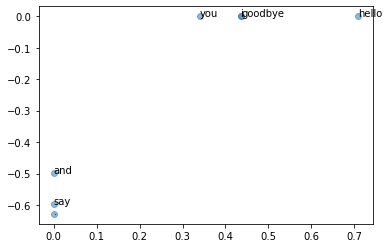

In [4]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:,0], U[:,1],  alpha=0.5)
plt.show()

## PTB 데이터셋

In [7]:
import sys
sys.path.append('..')
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb

window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산...')
C = create_co_matrix(corpus, vocab_size, window_size)
W = ppmi(C, verbose = True)

동시발생 수 계산...


C:\Users\ykm25\DLFromScratch2\common\util.py:134: RuntimeWarning: overflow encountered in long_scalars
  pmi = np.log2(C[i, j] * N / (S[i]*S[j]) + eps)
C:\Users\ykm25\DLFromScratch2\common\util.py:134: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(C[i, j] * N / (S[i]*S[j]) + eps)


1.00 완료
2.00 완료
3.00 완료
4.00 완료
5.00 완료
6.00 완료
7.00 완료
8.00 완료
9.00 완료
10.00 완료
11.00 완료
12.00 완료
13.00 완료
14.00 완료
15.00 완료
16.00 완료
17.00 완료
18.00 완료
19.00 완료
20.00 완료
21.00 완료
22.00 완료
23.00 완료
24.00 완료
25.00 완료
26.00 완료
27.00 완료
28.00 완료
29.00 완료
30.00 완료
31.00 완료
32.00 완료
33.00 완료
34.00 완료
35.00 완료
36.00 완료
37.00 완료
38.00 완료
39.00 완료
40.00 완료
41.00 완료
42.00 완료
43.00 완료
44.00 완료
45.00 완료
46.00 완료
47.00 완료
48.00 완료
49.00 완료
50.00 완료
51.00 완료
52.00 완료
53.00 완료
54.00 완료
55.00 완료
56.00 완료
57.00 완료
58.00 완료
59.00 완료
60.00 완료
61.00 완료
62.00 완료
63.00 완료
64.00 완료
65.00 완료
66.00 완료
67.00 완료
68.00 완료
69.00 완료
70.00 완료
71.00 완료
72.00 완료
73.00 완료
74.00 완료
75.00 완료
76.00 완료
77.00 완료
78.00 완료
79.00 완료
80.00 완료
81.00 완료
82.00 완료
83.00 완료
84.00 완료
85.00 완료
86.00 완료
87.00 완료
88.00 완료
89.00 완료
90.00 완료
91.00 완료
92.00 완료
93.00 완료
94.00 완료
95.00 완료
96.00 완료
97.00 완료
98.00 완료
99.00 완료
100.00 완료


In [8]:
try:
    # truncated SVD
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except:
    # SVD
    U, S, V = np.linalg.svd(W)

    
word_vecs = U[:, :wordvec_size]
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 i: 0.6984682679176331
 we: 0.6044149994850159
 do: 0.5949453115463257
 anybody: 0.584631621837616
 'd: 0.525708019733429

[query] year
 earlier: 0.662046492099762
 month: 0.6441275477409363
 last: 0.6324495077133179
 quarter: 0.6240189671516418
 next: 0.593936026096344

[query] car
 luxury: 0.5601484775543213
 cars: 0.5449755787849426
 auto: 0.5238342881202698
 truck: 0.52365642786026
 vehicle: 0.5158299207687378

[query] toyota
 motor: 0.7549260258674622
 nissan: 0.6835561990737915
 motors: 0.67510586977005
 mazda: 0.6597824692726135
 honda: 0.6356290578842163
